In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testing/WhatsApp Image 2025-05-29 at 20.28.26_297b7a2f.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0245.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0250.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0277.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0239.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0229.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0208.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0204.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0223.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0243.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0227.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0287.jpg
/kaggle/input/computer-vision-info-educatie/yellow/IMG-20250529-WA0270.jpg
/kaggle/input/computer-visi

In [52]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import classification_report

In [53]:
path = '/kaggle/input/computer-vision-info-educatie'

In [54]:
def folder_to_label(color):
    if color == 'yellow':
        return 0
    elif color == 'blue':
        return 0
    elif color == 'green':
        return 0
    return 1

In [55]:
class data(Dataset):
    def __init__(self, path):
        self.images = []
        self.label = []

        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
            transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=1),
            transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        for folder in os.listdir(path):
            for img in os.listdir(os.path.join(path, folder)):
                self.images.append(os.path.join(path, folder, img))
                self.label.append(folder_to_label(folder))
                
    def __len__(self):
        return len(self.label)
        
    def __getitem__(self,index):
        input_img = self.transform(Image.open(self.images[index]).convert('RGB'))
        output_label = torch.tensor(self.label[index])
        return input_img, output_label    

In [56]:
dataset = data(path)

In [57]:
train_dataset, valid_dataset, test_dataset = random_split(dataset, [int(0.8 * len(dataset)), int(0.1 * len(dataset)), len(dataset) - int(0.1 * len(dataset)) - int(0.8 * len(dataset))])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [58]:
def Linear(input_features, output_features):
    layer = nn.Sequential(
        nn.Linear(input_features, output_features),
        nn.ReLU(),
        nn.Dropout(0.4)
    )
    return layer

In [59]:
def Conv(input_features, output_features, kernel_sz):
    convolution = nn.Sequential(
        nn.Conv2d(in_channels=input_features, out_channels=output_features, kernel_size=kernel_sz, stride = 2),
        nn.BatchNorm2d(output_features),
        nn.ReLU(),
        nn.MaxPool2d((2,2), 2),
        nn.Dropout2d(0.4)
    )
    return convolution

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [61]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [62]:
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)

in_features = model.heads[0].in_features

model.heads = nn.Sequential(nn.Linear(in_features, 2))
model = model.to(device)

In [63]:
weight = torch.tensor([1.0, 253 / 78], dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
softmax = nn.Softmax(dim=-1)
epochs = 8

In [64]:
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []

In [65]:
for epoch in range(epochs):
    model.train()
    predictions = []
    ground_truth = []
    running_loss = 0.0

    dataloader = tqdm(train_dataloader, desc=f"Training on epoch {epoch + 1}...", leave=False)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        running_loss += loss.item()

        preds = torch.argmax(softmax(y_hat), dim=1)
        predictions.extend(preds.cpu().numpy())
        ground_truth.extend(y.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_train_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)
    print(f"Training epoch {epoch + 1} - Loss: {epoch_train_loss:.4f}")
    print("Classification Report (Train):")
    print(classification_report(ground_truth, predictions))

    # Evaluation
    model.eval()
    predictions = []
    ground_truth = []
    running_loss = 0.0

    with torch.no_grad():
        dataloader = tqdm(valid_dataloader, desc=f"Validating on epoch {epoch + 1}...", leave=False)
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            running_loss += loss.item()

            preds = torch.argmax(softmax(y_hat), dim=1)
            predictions.extend(preds.cpu().numpy())
            ground_truth.extend(y.cpu().numpy())

    epoch_valid_loss = running_loss / len(valid_dataloader)
    valid_losses.append(epoch_valid_loss)
    print(f"Validation epoch {epoch + 1} - Loss: {epoch_valid_loss:.4f}")
    print("Classification Report (Validation):")
    print(classification_report(ground_truth, predictions))

Training epoch 1 - Loss: 0.6785
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.79      0.50      0.61       250
           1       0.28      0.59      0.38        81

    accuracy                           0.52       331
   macro avg       0.53      0.54      0.49       331
weighted avg       0.66      0.52      0.55       331



Validation epoch 1 - Loss: 0.4792
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        34
           1       0.60      0.43      0.50         7

    accuracy                           0.85        41
   macro avg       0.74      0.68      0.71        41
weighted avg       0.84      0.85      0.84        41



Training epoch 2 - Loss: 0.4307
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       250
           1       0.80      0.68      0.73        81

    accuracy                           0.88       331
   macro avg       0.85      0.81      0.83       331
weighted avg       0.88      0.88      0.88       331



Validation epoch 2 - Loss: 0.3848
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96        34
           1       0.83      0.71      0.77         7

    accuracy                           0.93        41
   macro avg       0.89      0.84      0.86        41
weighted avg       0.92      0.93      0.92        41



Training epoch 3 - Loss: 0.2892
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       250
           1       0.86      0.94      0.90        81

    accuracy                           0.95       331
   macro avg       0.92      0.95      0.93       331
weighted avg       0.95      0.95      0.95       331



Validation epoch 3 - Loss: 0.2436
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.86      0.86      0.86         7

    accuracy                           0.95        41
   macro avg       0.91      0.91      0.91        41
weighted avg       0.95      0.95      0.95        41



Training epoch 4 - Loss: 0.1979
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       250
           1       0.93      0.98      0.95        81

    accuracy                           0.98       331
   macro avg       0.96      0.98      0.97       331
weighted avg       0.98      0.98      0.98       331



Validation epoch 4 - Loss: 0.1919
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        34
           1       0.78      1.00      0.88         7

    accuracy                           0.95        41
   macro avg       0.89      0.97      0.92        41
weighted avg       0.96      0.95      0.95        41



Training epoch 5 - Loss: 0.1224
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       250
           1       0.98      1.00      0.99        81

    accuracy                           0.99       331
   macro avg       0.99      1.00      0.99       331
weighted avg       0.99      0.99      0.99       331



Validation epoch 5 - Loss: 0.1017
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00         7

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



Training epoch 6 - Loss: 0.0879
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       250
           1       0.96      1.00      0.98        81

    accuracy                           0.99       331
   macro avg       0.98      0.99      0.99       331
weighted avg       0.99      0.99      0.99       331



Validation epoch 6 - Loss: 0.1004
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      0.86      0.92         7

    accuracy                           0.98        41
   macro avg       0.99      0.93      0.95        41
weighted avg       0.98      0.98      0.97        41



Training epoch 7 - Loss: 0.0594
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       0.99      1.00      0.99        81

    accuracy                           1.00       331
   macro avg       0.99      1.00      1.00       331
weighted avg       1.00      1.00      1.00       331



Validation epoch 7 - Loss: 0.0777
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00         7

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



Training epoch 8 - Loss: 0.0375
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      1.00      1.00        81

    accuracy                           1.00       331
   macro avg       1.00      1.00      1.00       331
weighted avg       1.00      1.00      1.00       331



Validation epoch 8 - Loss: 0.0578
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.88      1.00      0.93         7

    accuracy                           0.98        41
   macro avg       0.94      0.99      0.96        41
weighted avg       0.98      0.98      0.98        41



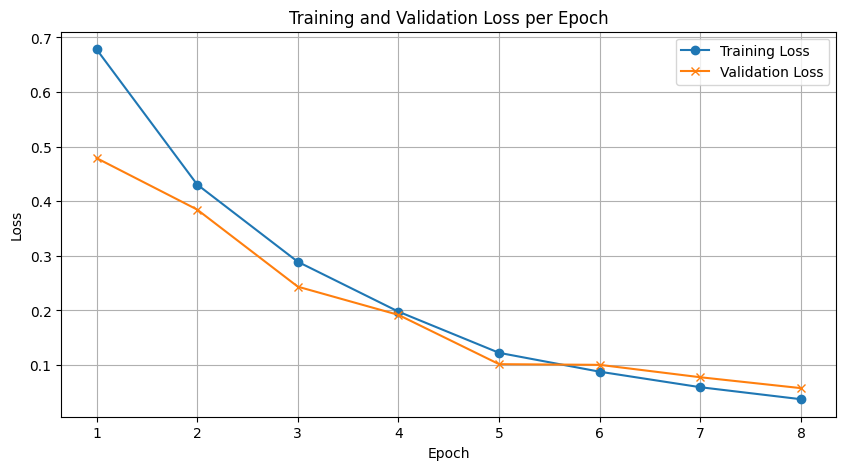

In [66]:
# Plot after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, 9), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, 9), valid_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
model.eval()
predictions = []
ground_truth = []
running_loss = 0.0

with torch.no_grad():
    dataloader = tqdm(test_dataloader, desc=f"Testing on epoch {epoch + 1}...", leave=False)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        running_loss += loss.item()

        preds = torch.argmax(softmax(y_hat), dim=1)
        predictions.extend(preds.cpu().numpy())
        ground_truth.extend(y.cpu().numpy())

running_loss /= len(test_dataloader)
print(f"Validation epoch {epoch + 1} - Loss: {running_loss:.4f}")
print("Classification Report (Testing):")
print(classification_report(ground_truth, predictions))

Validation epoch 8 - Loss: 0.0934
Classification Report (Testing):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        12

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42



In [68]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [69]:
img_path = "/kaggle/input/testing5/WhatsApp Image 2025-05-29 at 22.16.34_288d61ff.jpg"
image = Image.open(img_path).convert('RGB')

transformed_image = transform(image)
transformed_image = transformed_image.unsqueeze(0)
transformed_image = transformed_image.to(device)

In [70]:
with torch.no_grad():
    output = model(transformed_image)
    probs = torch.softmax(output, dim=1)
    print(probs)
    predicted_class = torch.argmax(probs, dim=1).item()

tensor([[0.1567, 0.8433]], device='cuda:0')


In [71]:
def color_to_label(color):
    if color == 'yellow':
        return 0
    elif color == 'blue':
        return 1
    return 2

In [72]:
class data_color(Dataset):
    def __init__(self, path):
        self.images = []
        self.label = []

        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
            transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        for folder in os.listdir(path):
            if folder != 'fake':
                for img in os.listdir(os.path.join(path, folder)):
                    self.images.append(os.path.join(path, folder, img))
                    self.label.append(color_to_label(folder))
                
    def __len__(self):
        return len(self.label)
        
    def __getitem__(self,index):
        input_img = self.transform(Image.open(self.images[index]).convert('RGB'))
        output_label = torch.tensor(self.label[index])
        return input_img, output_label    

In [73]:
dataset = data_color(path)

In [74]:
train_dataset, valid_dataset, test_dataset = random_split(dataset, [int(0.8 * len(dataset)), int(0.1 * len(dataset)), len(dataset) - int(0.1 * len(dataset)) - int(0.8 * len(dataset))])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [75]:
import torchvision.models as models

color_model = models.resnet18(pretrained=True)
color_model.fc = nn.Linear(color_model.fc.in_features, 3) 
color_model = color_model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [76]:
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []

In [77]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(color_model.parameters(), lr = 1e-4)
softmax = nn.Softmax(dim=-1)
epochs = 3

In [78]:
for epoch in range(epochs):
    color_model.train()
    predictions = []
    ground_truth = []
    running_loss = 0.0

    dataloader = tqdm(train_dataloader, desc=f"Training on epoch {epoch + 1}...", leave=False)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_hat = color_model(X)
        loss = loss_fn(y_hat, y)
        running_loss += loss.item()

        preds = torch.argmax(softmax(y_hat), dim=1)
        predictions.extend(preds.cpu().numpy())
        ground_truth.extend(y.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_train_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_train_loss)
    print(f"Training epoch {epoch + 1} - Loss: {epoch_train_loss:.4f}")
    print("Classification Report (Train):")
    print(classification_report(ground_truth, predictions))

    # Evaluation
    color_model.eval()
    predictions = []
    ground_truth = []
    running_loss = 0.0

    with torch.no_grad():
        dataloader = tqdm(valid_dataloader, desc=f"Validating on epoch {epoch + 1}...", leave=False)
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_hat = color_model(X)
            loss = loss_fn(y_hat, y)
            running_loss += loss.item()

            preds = torch.argmax(softmax(y_hat), dim=1)
            predictions.extend(preds.cpu().numpy())
            ground_truth.extend(y.cpu().numpy())

    epoch_valid_loss = running_loss / len(valid_dataloader)
    valid_losses.append(epoch_valid_loss)
    print(f"Validation epoch {epoch + 1} - Loss: {epoch_valid_loss:.4f}")
    print("Classification Report (Validation):")
    print(classification_report(ground_truth, predictions))

Training epoch 1 - Loss: 0.8679
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.48      0.91      0.63        91
           1       0.73      0.35      0.48        62
           2       0.78      0.39      0.52        98

    accuracy                           0.57       251
   macro avg       0.66      0.55      0.54       251
weighted avg       0.66      0.57      0.55       251



Validation epoch 1 - Loss: 0.5813
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       1.00      0.31      0.47        13
           2       0.58      1.00      0.74         7

    accuracy                           0.71        31
   macro avg       0.77      0.77      0.68        31
weighted avg       0.81      0.71      0.66        31



Training epoch 2 - Loss: 0.1986
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        91
           1       0.95      0.98      0.97        62
           2       0.99      0.96      0.97        98

    accuracy                           0.98       251
   macro avg       0.98      0.98      0.98       251
weighted avg       0.98      0.98      0.98       251



Validation epoch 2 - Loss: 0.1132
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         7

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



Training epoch 3 - Loss: 0.0468
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        91
           1       0.97      1.00      0.98        62
           2       1.00      0.98      0.99        98

    accuracy                           0.99       251
   macro avg       0.99      0.99      0.99       251
weighted avg       0.99      0.99      0.99       251



Validation epoch 3 - Loss: 0.0168
Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         7

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



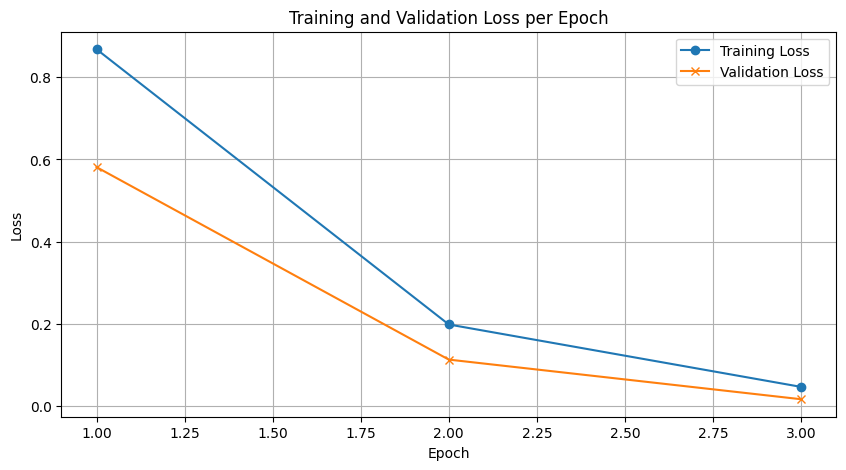

In [79]:
# Plot after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, 3 + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, 3 + 1), valid_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [80]:
color_model.eval()
predictions = []
ground_truth = []
running_loss = 0.0

with torch.no_grad():
    dataloader = tqdm(test_dataloader, desc=f"Testing on epoch {epoch + 1}...", leave=False)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_hat = color_model(X)
        loss = loss_fn(y_hat, y)
        running_loss += loss.item()

        preds = torch.argmax(softmax(y_hat), dim=1)
        predictions.extend(preds.cpu().numpy())
        ground_truth.extend(y.cpu().numpy())

running_loss /= len(test_dataloader)
print(f"Validation epoch {epoch + 1} - Loss: {running_loss:.4f}")
print("Classification Report (Testing):")
print(classification_report(ground_truth, predictions))

Validation epoch 3 - Loss: 0.0180
Classification Report (Testing):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        14

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



**Check manually one picture just cause i want to**

In [81]:
import torchvision.transforms as transforms

In [82]:
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [83]:
img_path = "/kaggle/input/testing5/WhatsApp Image 2025-05-29 at 22.16.34_288d61ff.jpg"
image = Image.open(img_path).convert("RGB")

input_tensor = transform(image)

input_tensor = input_tensor.unsqueeze(0)

input_tensor = input_tensor.to(device)

In [84]:
with torch.no_grad():
    output = color_model(input_tensor)
    probs = torch.softmax(output, dim=1)
    print(probs)
    predicted_class = torch.argmax(probs, dim=1).item()

tensor([[0.0014, 0.0070, 0.9916]], device='cuda:0')


**Save models**

In [86]:
torch.save(model.state_dict(), 'trash_or_no_trash.pth')
torch.save(color_model.state_dict(), 'color_trash.pth')